In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ReLU
from torch.utils.data import Dataset
from  torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
import model.squeezenet as squeezenet
import model.densenet as densenet
import model.resnet as resnet
from tqdm import tqdm
import os
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#-------------------------------------------------------------------------------------------
np.random.seed(999)
TRAINING_SAMPLES = 50000#20000
TESTING_SAMPLES = 10000 #2000

N_GRID = 56
n_grid = 5
n_subhalos = N_GRID**2

show_test_imgs = False
data_transform = transforms.Compose([
            transforms.ToTensor(), # scale to [0,1] and convert to tensor
            ])
target_transform = torch.Tensor

# This function create a N_GRID x N_GRID zeros matrix and insert a n_grid x n_grid gaussian distribution
# in the (x_t, y_t), notice n_grid must be an odd number.
def target2density(x_t,y_t,N_GRID,n_grid):
    N, n = N_GRID,n_grid
    x, y = np.meshgrid(np.linspace(-1,1,n), np.linspace(-1,1,n))
    d = np.sqrt(x*x+y*y)
    sigma, mu = 1.0, 0.0
    g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
    G = np.zeros((N,N))
    y_t = int(N/2 + y_t*N/2)
    x_t = int(N/2 + x_t*N/2)
    grid_shape = G[y_t-n//2:y_t+1+n//2,x_t-n//2:x_t+1+n//2].shape
    G[y_t-n//2:y_t+1+n//2,x_t-n//2:x_t+1+n//2] = g[:grid_shape[0],:grid_shape[1]]

    return G






class DMSDataset(Dataset): # torch.utils.data.Dataset
    def __init__(self, root_dir,dataset_index, n_grid, train=True, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.n_grid = n_grid
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set
        self.train_folder = 'train_'+str(dataset_index)
        self.test_folder = 'test_'+str(dataset_index)

        if self.train:
            self.path = os.path.join(self.root_dir, self.train_folder)
            self.length = TRAINING_SAMPLES
        else:
            self.path = os.path.join(self.root_dir, self.test_folder)
            self.length = TESTING_SAMPLES

    def __getitem__(self, index):

        
        
        ### Code for getting lens image (with subhalos)
        lens_img_path = self.path + '/output_lens_%07d.npy' % (index+1)
        lens_img = np.load(lens_img_path)
        

        ### code for the smooth model (lens image without any subhalo)
        smooth_model_path = self.path + "/smooth_lens_%07d.npy" % (index+1)
        smooth_model = np.load(smooth_model_path)

        
        ### code for the source galaxy
        lens_source_path = self.path + '/lens_source_%07d.npy' % (index+1)
        lens_source = np.load(lens_source_path)
        
        ### Code for getting detectable subhalo Kapp Map
        detectable_target_subhalo_kappa_density_path = self.path + '/detectable_subhalo_kappa_log10_%07d.npy' % (index+1)
        detectable_kappa_log_10 = np.load(detectable_target_subhalo_kappa_density_path)
        
        all_target_subhalo_kappa_density_path = self.path + '/subhalo_kappa_log10_%07d.npy' % (index+1)
        all_kappa_log_10 = np.load(all_target_subhalo_kappa_density_path)
        
        ### Code for adding noise
#         sigma_n = 1.0
#         gaussian_noise = np.random.randn(224, 224) * sigma_n
#         lens_img += gaussian_noise


    


        ### Code for getting detectable subhalo counts 
        detectable_num_subhalo_path = self.path + '/detectable_num_subhalo_%07d.npy' % (index+1)
        detectable_num_subhalo = np.load(detectable_num_subhalo_path)

        ### Code for getting detectable dark matter subhalos positions
        target_subhalo_density_path = self.path + '/detectable_pos_sub_%07d.npy' % (index+1)
        target_subhalo_density_orig = np.load(target_subhalo_density_path)
        
        ### Code for getting all dark matter subhalos positions
        target_all_subhalo_density_path = self.path + '/pos_sub_%07d.npy' % (index+1)
        target_all_subhalo_density_orig = np.load(target_all_subhalo_density_path)

        target_subhalo_density = np.zeros((N_GRID, N_GRID))
        all_subhalo_density = np.zeros((N_GRID, N_GRID))

        
        ### Code for transforming subhalo positions (scalars) to probability map (matrix)
        if detectable_num_subhalo > 0:
            # only one subhalo
            if len(target_subhalo_density_orig.shape) == 1:
                if len(target_subhalo_density_orig) == 2:
                    density = target2density(*target_subhalo_density_orig , N_GRID, self.n_grid)
                    target_subhalo_density += density
            # multiple subhalos, and detectable subhalos are placed in the first few items
            else:
                for i in range(len(target_subhalo_density_orig)):
                    if len(target_subhalo_density_orig[i]) == 2:
                        density = target2density(*target_subhalo_density_orig[i], N_GRID, self.n_grid)
                        target_subhalo_density += density

            target_subhalo_density = np.clip(target_subhalo_density,0,1)
    
        # only one subhalo
        if len(target_all_subhalo_density_orig.shape) == 1:
            if len(target_subhalo_density_orig) == 2:
                all_density = target2density(*target_all_subhalo_density_orig , N_GRID, self.n_grid)
                all_subhalo_density += all_density
        # multiple subhalos, and detectable subhalos are placed in the first few items
        else:
            for i in range(len(target_all_subhalo_density_orig)):
                if len(target_all_subhalo_density_orig[i]) == 2:
                    all_density = target2density(*target_all_subhalo_density_orig[i], N_GRID, self.n_grid)
                    all_subhalo_density += all_density
        
        all_subhalo_density = np.clip(all_subhalo_density, 0, 1)
        

        lens_image = Image.fromarray(lens_img).convert("RGB")
        smooth_model_image = Image.fromarray(smooth_model).convert("RGB")
        lens_source_image = Image.fromarray(lens_source).convert("RGB")
         

        if self.transform is not None:
            data = self.transform(lens_image.copy())

        if self.target_transform is not None:
            target_subhalo = self.target_transform(target_subhalo_density.copy())
            #has_subhalo = self.target_transform(np.asarray(has_subhalo))
            
        
        return data, lens_image, smooth_model_image, lens_source_image, target_subhalo, all_subhalo_density,  target_subhalo_density\
    , detectable_kappa_log_10, all_kappa_log_10

    def __len__(self):
        return self.length

def sigmoid(x):
    return 1/(1+np.exp(-x))
            
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
def Visualization(net,model_name, dataset, folder, num_test):

    for i in range(num_test):
        data, lens_image, smooth_model_image, lens_source_image, target_subhalo, all_subhalo_density,  target_subhalo_density\
        , detectable_kappa_log_10, all_kappa_log_10= dataset[i]
        data_v = Variable(data.unsqueeze(0)).cuda()
        output_macro,output_micro,output_source  = net(data_v)

#         output_macro = output_macro.detach().cpu().numpy()
#         output_macro[-1] = sigmoid(output_macro[-1])

        output_micro = output_micro.detach().cpu().numpy()
        output_micro = sigmoid(output_micro)
        
#         output_source = output_source.detach().cpu().numpy()
#         output_source = output_source

        img = lens_image#.detach().cpu()

        orig_img = img#.copy()
        #if has_subhalo:
        #orig_img_target = target_original
        #orig_img_target_mass = target_subhalo_mass_original
#         else:
#             orig_img_target = np.zeros_like(target_original)
#             orig_img_target_mass = np.zeros_like(target_subhalo_mass_original)
            
        #output_source = cv2.resize(output_source,(224,224))
        
        
        orig_img = np.asarray(orig_img/ np.max(orig_img) * 255., dtype=np.int32)
        lens_image = np.asarray(lens_image/ np.max(lens_image) * 255., dtype=np.int32)
        smooth_model_image = np.asarray(smooth_model_image/ np.max(smooth_model_image) * 255., dtype=np.int32)
        lens_source_image = np.asarray(lens_source_image/ np.max(lens_source_image) * 255., dtype=np.int32)
        plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k') 
        plt.subplots_adjust(wspace=0.3)
        plt.subplot(1,3,1)
        plt.imshow(lens_image)
        plt.title("lensing image")

        plt.subplot(1,3,2)
        plt.imshow(smooth_model_image)
        plt.title("smooth model")
        #plt.show()
        
        plt.subplot(1,3,3)
        plt.imshow(lens_source_image)
        plt.title("source galaxy")
        plt.show()
        

        plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k') 
        #ax = plt.gca()
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.05)
        
        plt.subplot(1,3,1)
        plt.subplots_adjust(wspace=0.3)
        im1 = plt.imshow(all_subhalo_density)
        plt.colorbar(mappable=im1, fraction=0.046, pad=0.04)
        plt.title("all subhalo (ground truth)")

        plt.subplot(1,3,2)
        im2 = plt.imshow(target_subhalo, clim=(0.0, 1.0))
        plt.colorbar(mappable=im2, fraction=0.046, pad=0.04)
        plt.title("detectable subhalo (ground truth)")

        

        plt.subplot(1,3,3)
        im3 = plt.imshow(output_micro, clim=(0.0, 1.0))
        plt.title("subhalo (prediction)")
        plt.colorbar(mappable=im3, fraction=0.046, pad=0.04)
        plt.show()
        
        plt.subplot(1, 2, 1)
        plt.imshow(detectable_kappa_log_10)
        plt.title("detectable kappa log 10")
        
        plt.subplot(1, 2, 2)
        plt.imshow(all_kappa_log_10)
        plt.title("all kappa log 10")
        plt.show()
        
        
#         plt.imshow(lens_source)
#         plt.title("source galaxy")
#         plt.show()


        print('#-------------------------------------------------------------------------')

loaded densenet_5!
Total number of trainable parameters:  7660427


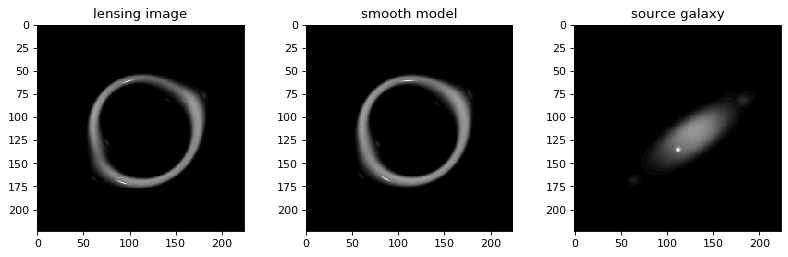

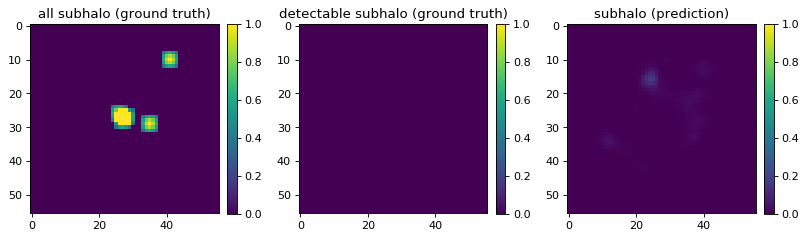

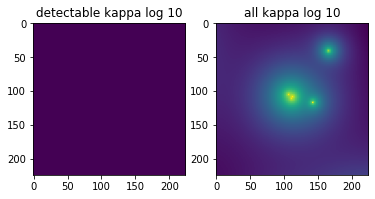

#-------------------------------------------------------------------------


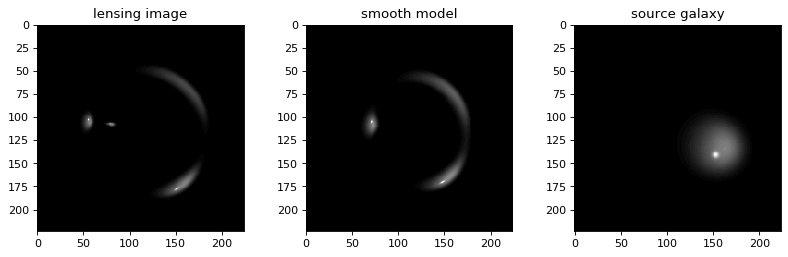

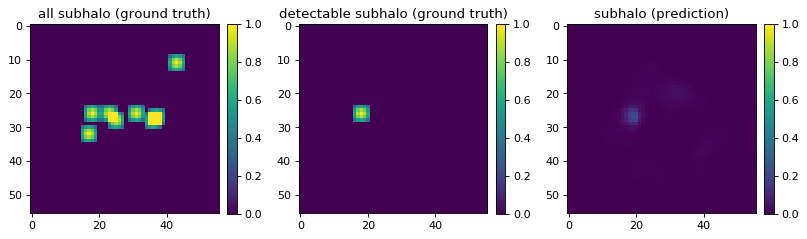

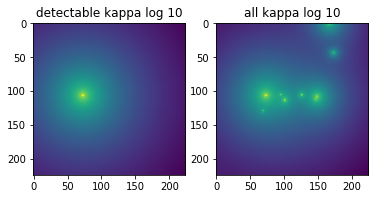

#-------------------------------------------------------------------------


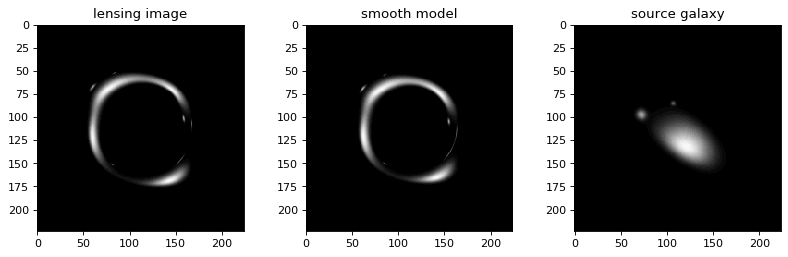

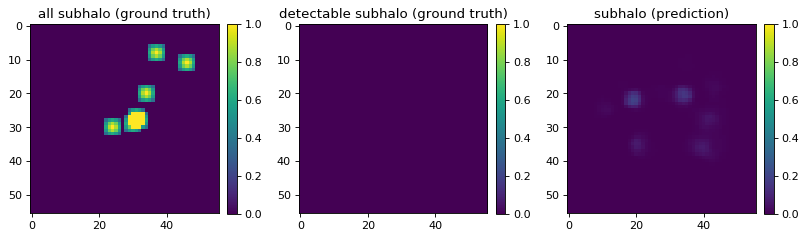

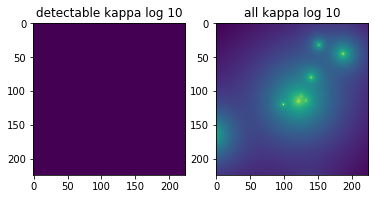

#-------------------------------------------------------------------------


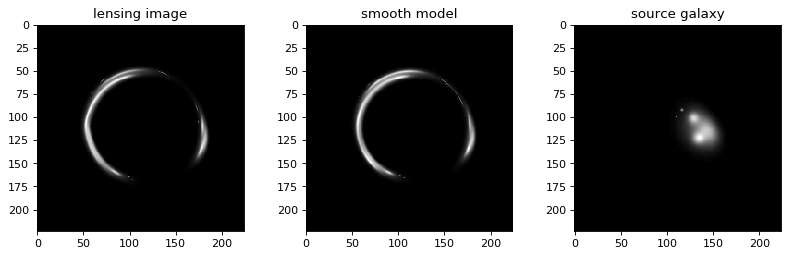

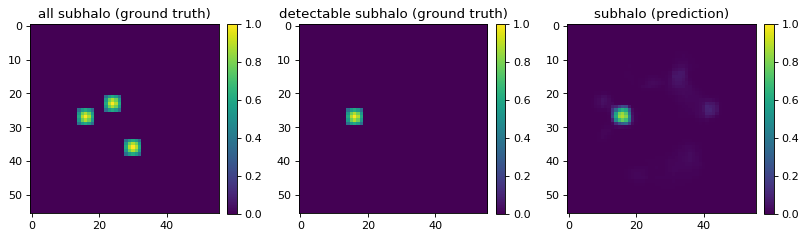

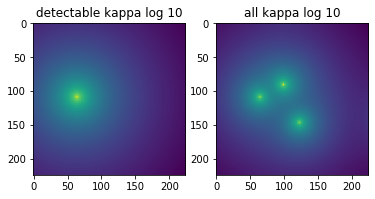

#-------------------------------------------------------------------------


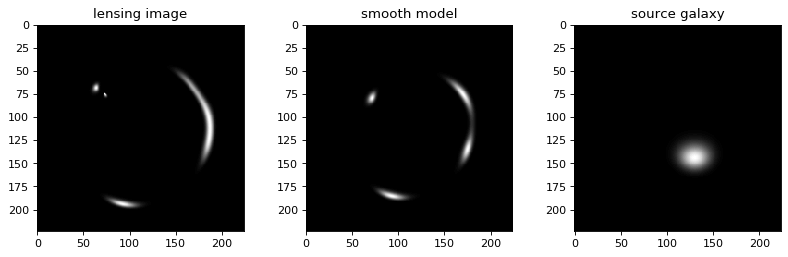

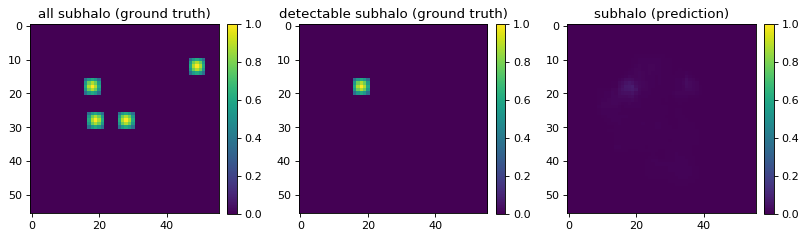

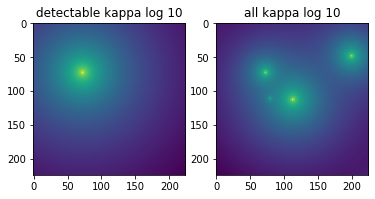

#-------------------------------------------------------------------------


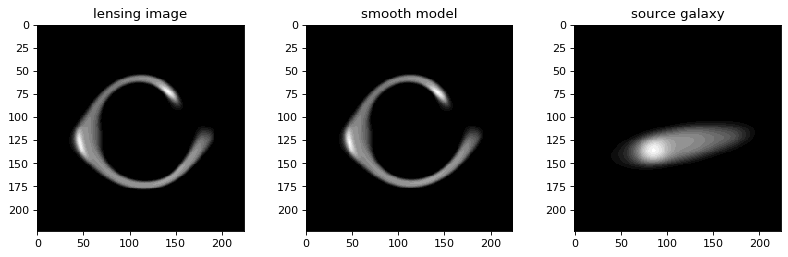

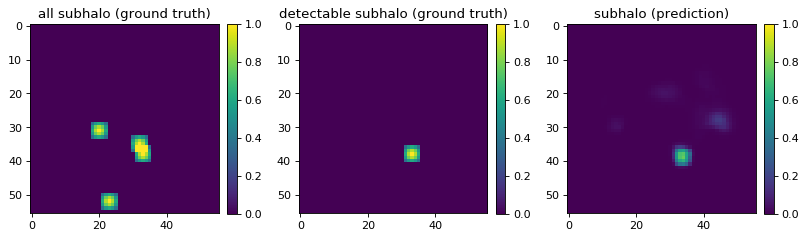

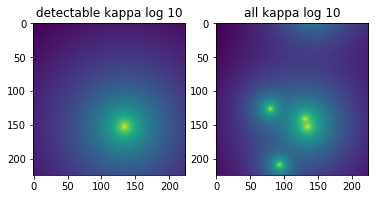

#-------------------------------------------------------------------------


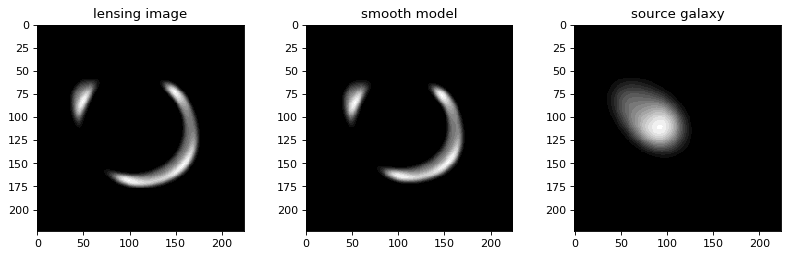

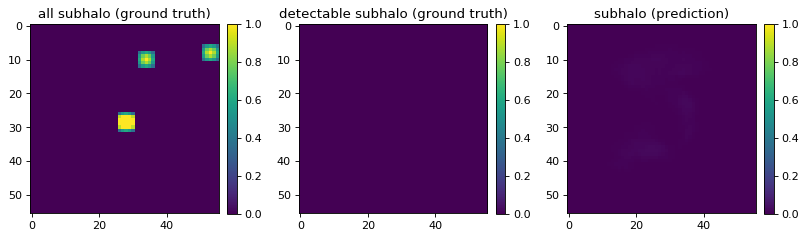

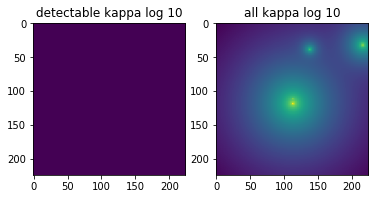

#-------------------------------------------------------------------------


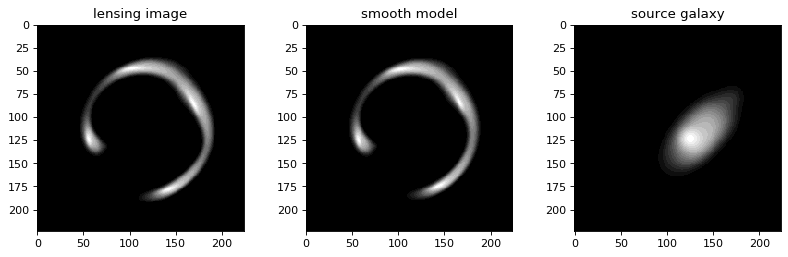

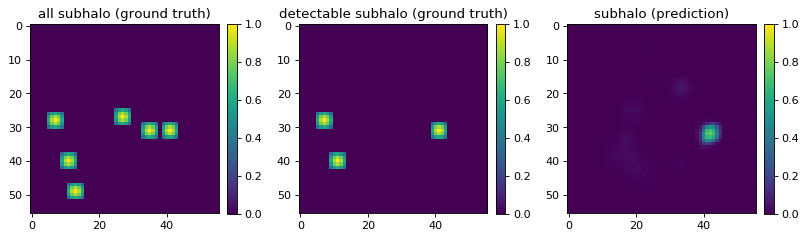

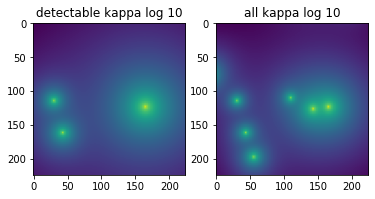

#-------------------------------------------------------------------------


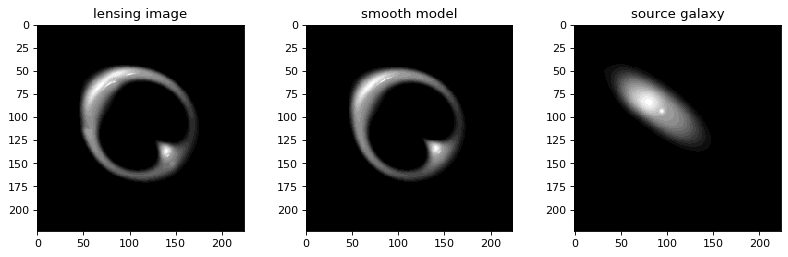

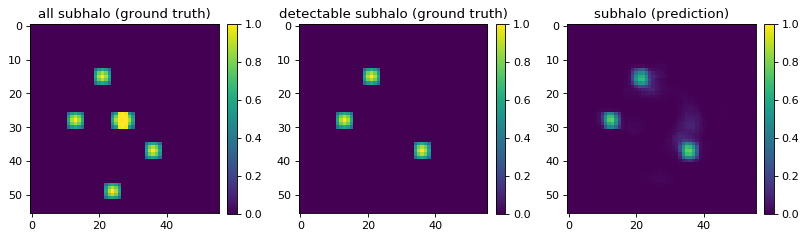

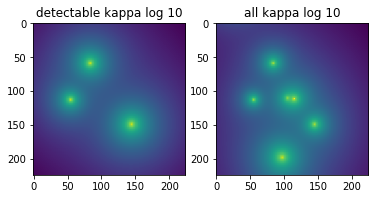

#-------------------------------------------------------------------------


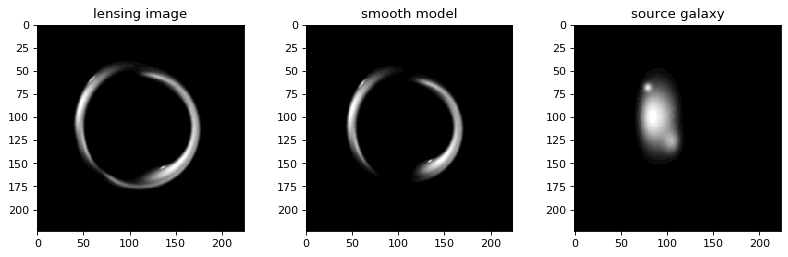

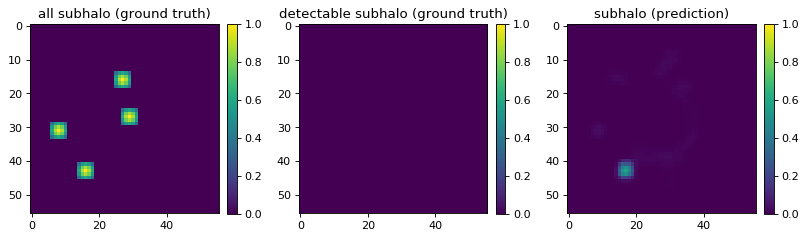

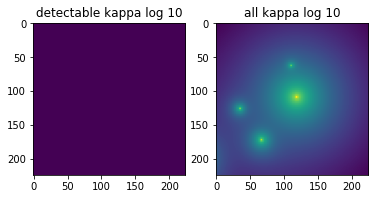

#-------------------------------------------------------------------------


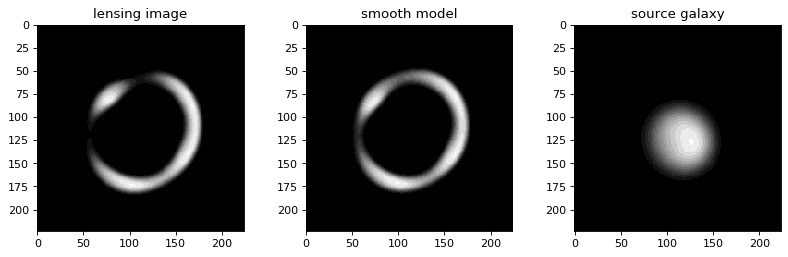

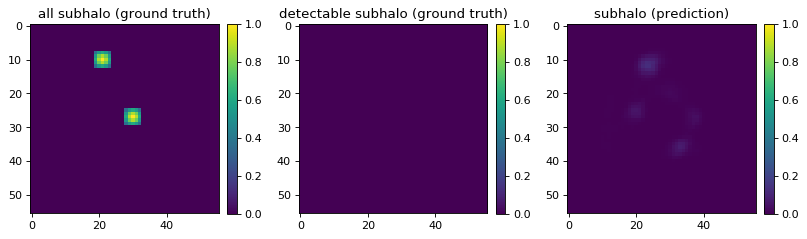

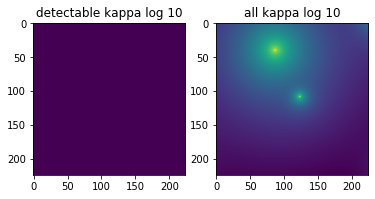

#-------------------------------------------------------------------------


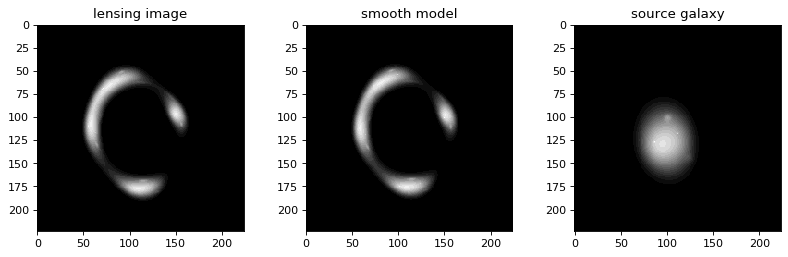

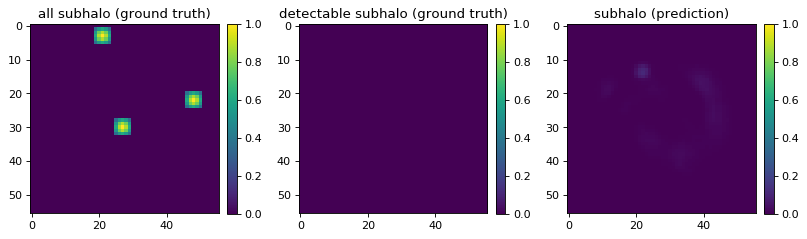

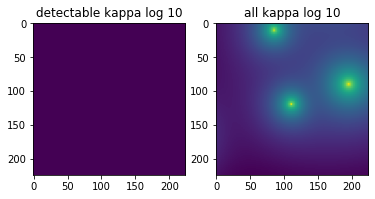

#-------------------------------------------------------------------------


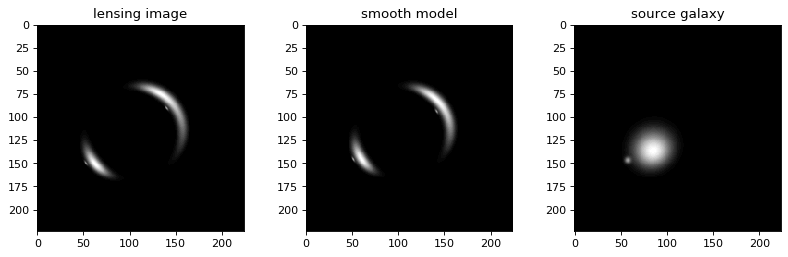

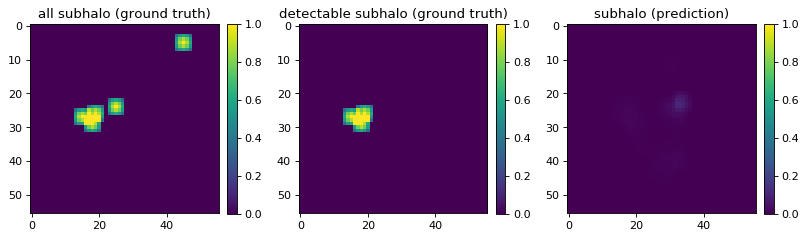

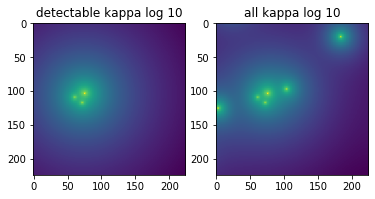

#-------------------------------------------------------------------------


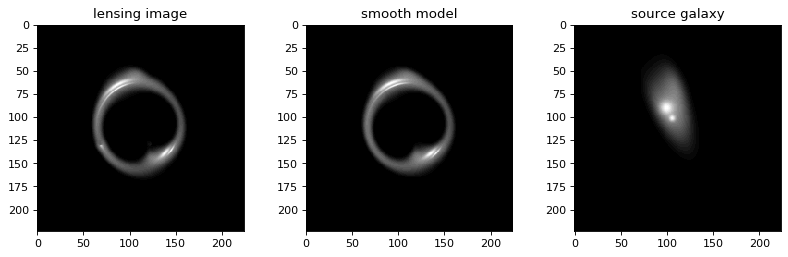

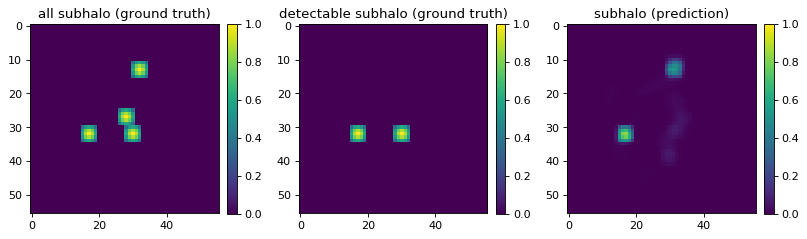

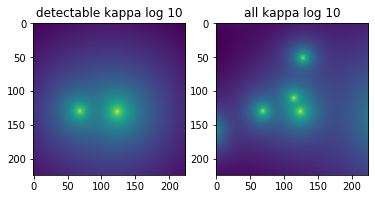

#-------------------------------------------------------------------------


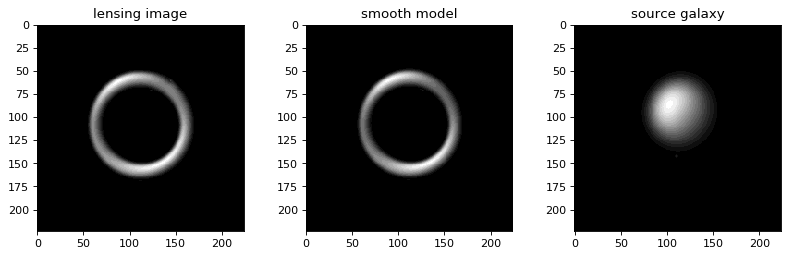

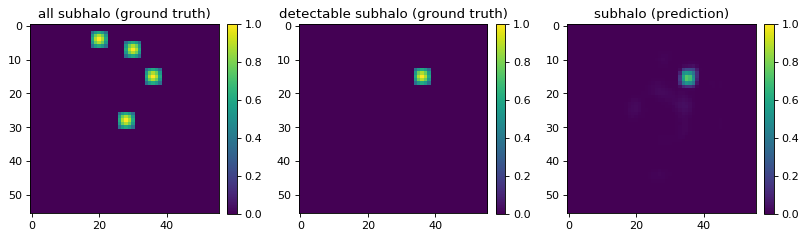

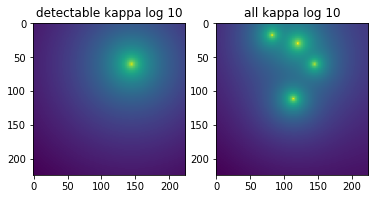

#-------------------------------------------------------------------------


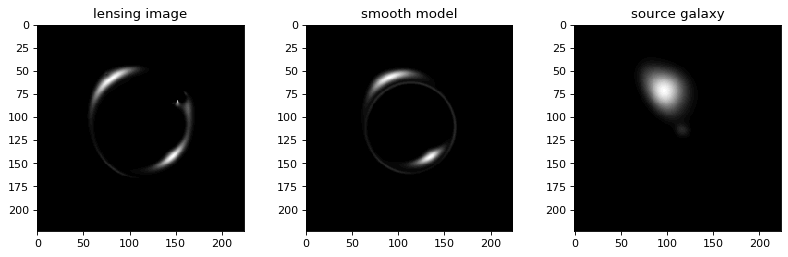

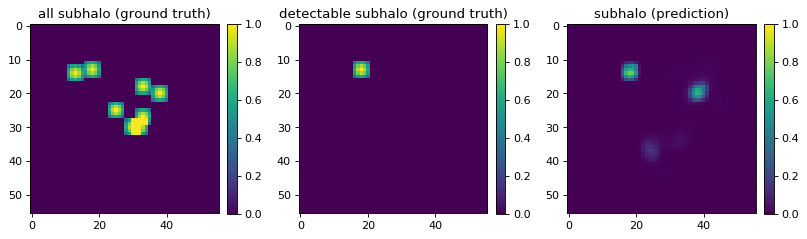

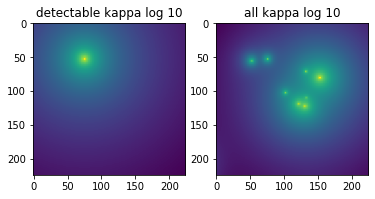

#-------------------------------------------------------------------------


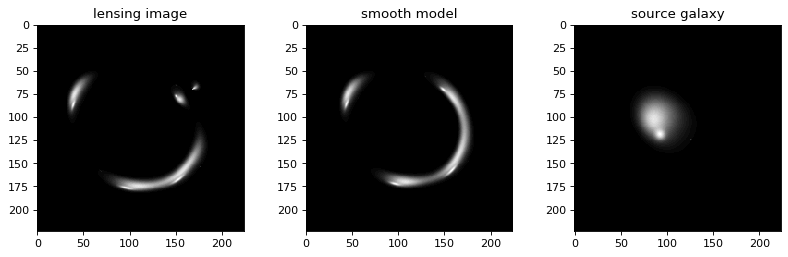

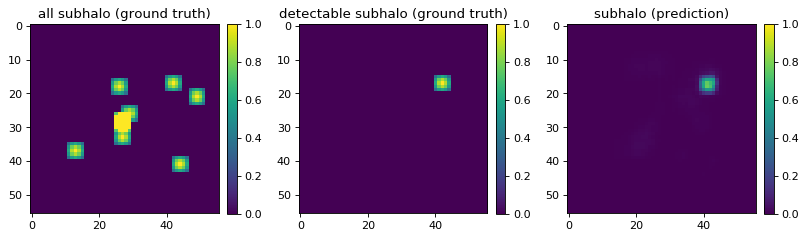

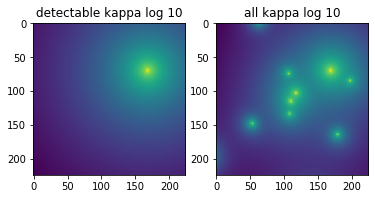

#-------------------------------------------------------------------------


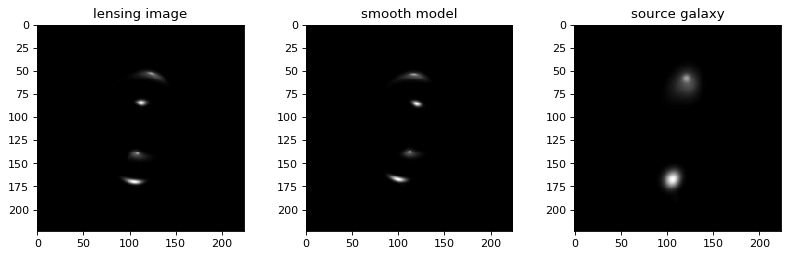

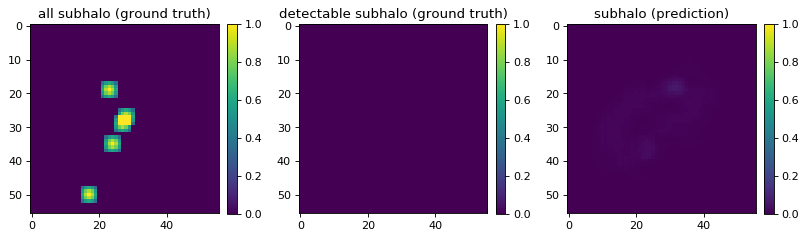

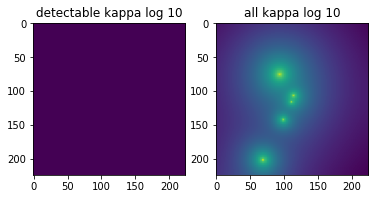

#-------------------------------------------------------------------------


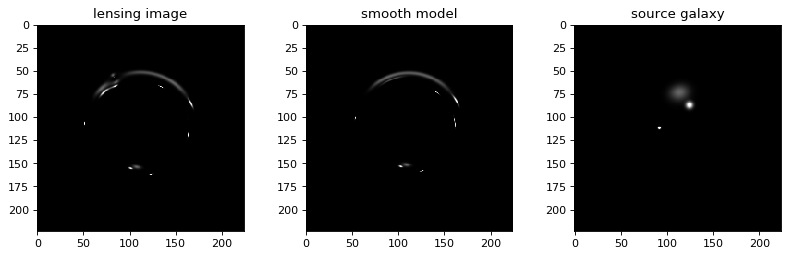

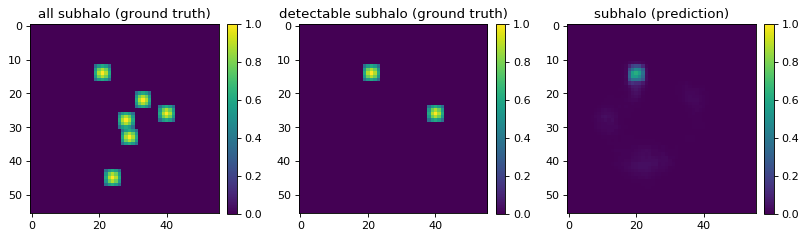

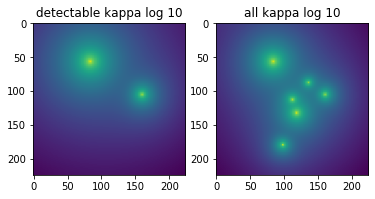

#-------------------------------------------------------------------------


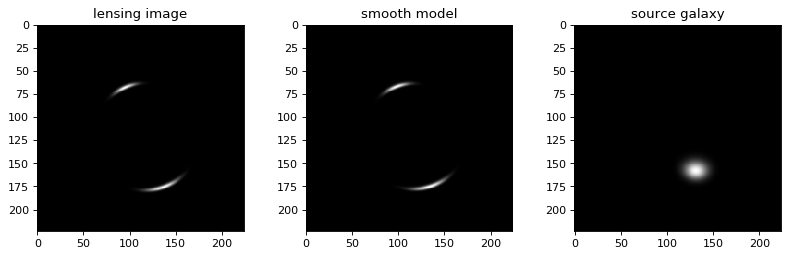

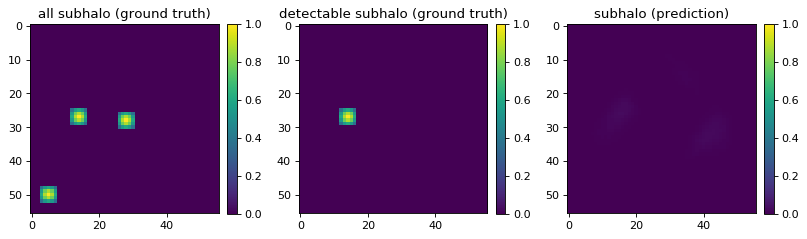

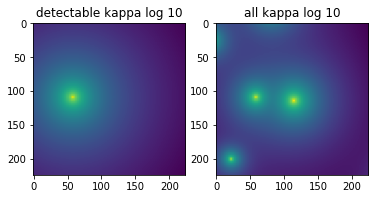

#-------------------------------------------------------------------------


In [4]:
#folder = '/media/joshua/38B6C6E7B6C6A4AA/v0710/'
folder = '/media/joshua/HDD_fun2/v0710/'
loaded_model_path = './0722_saved_model/'

model_names = ['densenet_5','squeezenet_5','resnet_5']

mod = model_names[0]

if os.path.exists(loaded_model_path):
    net = torch.load(loaded_model_path+mod)
    net.cuda()
    print('loaded {}!'.format(mod))

net.eval()
dataset = DMSDataset(folder,dataset_index=1, n_grid=int(mod[mod.find('_')+1:]), train=False,transform=data_transform, target_transform=target_transform)
SHOW_IMG = True
num_test = 20


print("Total number of trainable parameters: ", count_parameters(net))
Visualization(net, mod, dataset, folder, num_test)
del net